## Предсказание цен на недвижимость

In [1269]:
#ссылки на разделы

### Introduction

#### Постановка бизнес-задачи

- Используя данные из train.csv, построить
  модель для предсказания цен на недвижимость (квартиры) в России.
- С помощью полученной модели предсказать
  цены для квартир из файла test.csv.

- Метрики:
  - R2 - коэффициент детерминации (sklearn.metrics.r2_score > 0.6)
  - RMSE 


#### ML-задача

Решить задачу регрессии с помощью модели машинного обучения - предсказание цен на недвижимость на основании ее характеристик.
- Применить методы предобработки и подготовки данных для получения "чистых данных", проанализировать.
- Определить подходящие модели машинного обучения и построить их 
- Оценить качество работы моделей с помощью ML-метрики (MSE) и бизнес-метрик (R^2, RMSE) и выбрать наиболее эффективную
- Тюнинг финальной модели

#### План работы

1. Загрузка, первичное изучение данных и предобработка
2. Исследовательский анализ данных (EDA) и визуализация
3. Обработка пропусков и выбросов (data cleaning), генерация новых признаков (feature engineering).
4. Подготовка данных для подачи в ML-модели (определить необходимые признаки, стандартизировать значения, сплит данных обучающего датасета (train.csv)), сохранение стандартизованных данных
5. Построение моделей, оценка качества с помощью метрик, выбор наиболее эффетивной модели, ее сохранение.
6. Обработка тестового датасета (test.csv) и тест модели


#### Подключение библиотек и скриптов

In [1270]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.image as img
import seaborn as sns 
%matplotlib inline 
#%config InlineBackend.figure_format = 'svg' или 'retina'

# 2. Подготовка выборок для моделей
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 4. Метрики
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [1271]:
# 5. Дополнительно
import warnings 
warnings.filterwarnings('ignore')
#Зададим размер шрифта на графиках для всего ноутбука с помощью глобальной переменной
matplotlib.rcParams.update({'font.size': 14})

**Функции**

In [1272]:
#Уменьшим объем памяти датасета

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1273]:
def change_to_median(feature, n):
    """Заменить значения > n на медиану"""

    df.loc[df[feature] > n, feature] = df[feature].median()


def create_hist(feature, n):
    """Нарисовать гистограмму одного признака со значениями меньше n"""
    
    df.loc[df[feature] < n , feature].hist(figsize=(4, 4), bins=20, grid=False);
    
    
def create_jointplot(feature_1, feature_2):
    """Нарисовать зависимость двух переменных"""
    
    grid = sns.jointplot(df[feature_1], df[feature_2], kind='reg')
    grid.fig.set_figwidth(8)
    grid.fig.set_figheight(8)

    plt.show()
    
    
def create_boxplot_objfeature_price(objfeature):
    """Нарисовать распределение категориальных признаков относительно таргета - цены"""

    plt.figure(figsize=(16, 8))

    sns.boxplot(df['Price'], df['Shops_2'], whis=1.5)

    plt.xlabel('Price')
    plt.ylabel('Shops_2')
    plt.title(f'Distribution of Price by {objfeature}')
    plt.show()
    

In [1274]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

#### Пути к директориям и файлам

In [1275]:
TRAIN_DATASET_PATH = 'train.csv'
PREPARED_TRAIN_DATASET_PATH = 'train_prepared.csv'

TEST_DATASET_PATH = 'test.csv'

# REPORTS_FILE_PATH = './reports/'
# SCALER_FILE_PATH = './models/scaler.pkl'
# MODEL_FILE_PATH = './models/model.pkl'

TEST_DATASET_PRED_PATH = 'PolkovnikovaEA_predictions.csv'

### 1. Загрузка, первичное изучение данных и предобработка

**Описание датасета | Data Description**

Статистические данные о ряде жилых единиц в Российской Федерации, полученные в формате csv копии с сайта https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/data

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры, **целевая переменная**

Первичное изучение test.csv

In [1276]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

* В датасете 5 000 наблюдений (строк) и 19 признаков (столбцов).
* Наличие недостающих значений LifeSquare, Healthcare_1
* Типы данных float64(8), int64(9), object(Ecology_2, Ecology_3, Shops_2)

Первичное изучение train.csv

In [1277]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')

#Устаналиваем формат 2 цифры после точки в вещественных числах
# pd.options.display.float_format = '{:,.2f}'.format
# df.head(10)

In [1278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В датасете 10 000 наблюдений (строк) и 20 признаков (столбцов).

- 10 000 объектов с индексацией [0, 10000) с шагом=1
- Признаки (Column)
- Наличие недостающих значений LifeSquare, Healthcare_1
- Типы данных float64(8), int64(9), object(Ecology_2, Ecology_3, Shops_2)
- Использованная память 1.5+ MB

**Обзор количественных переменных**

Статистическая информация о каждом столбце с числовыми данными: среднее, минимальное, максимальное значение, среднеквадратичное отклонение и 50-й процентиль.

In [1279]:
df.describe(include=[np.number], percentiles=[.5]).transpose().drop('count', axis=1)

,mean,std,min,50%,max
Id,8383.407700,4859.019020,0.000000,8394.500000,1.679800e+04
DistrictId,50.400800,43.587592,0.000000,36.000000,2.090000e+02
Rooms,1.890500,0.839512,0.000000,2.000000,1.900000e+01
Square,56.315775,21.058732,1.136859,52.513310,6.410652e+02
LifeSquare,37.199645,86.241209,0.370619,32.781260,7.480592e+03
KitchenSquare,6.273300,28.560917,0.000000,6.000000,2.014000e+03
Floor,8.526700,5.241148,1.000000,7.000000,4.200000e+01
HouseFloor,12.609400,6.775974,0.000000,13.000000,1.170000e+02
HouseYear,3990.166300,200500.261427,1910.000000,1977.000000,2.005201e+07
Ecology_1,0.118858,0.119025,0.000000,0.075424,5.218671e-01


Из таблицы выше мы можем видеть, например, что средняя площадь квартиры (Square) в представленном датасете 56.32 со среднеквадратичным отклонением в 21.06. Минимальная площадь квартиры 0.37, максимальная - 641.07 с медианой 52.51. Аналогично мы можем получить информацию о других переменных.
А также предварительно увидеть, что некоторые признаки содержат выбросы, например, LifeSquare, KitchenSquare.
HouseYear - здесь неинформативно, т.к. в датафрейме перечислены года, но видим, что значение max выходит за пределы текущего года.

Ненужный столбец  Id (его удалим т.к. он дублирует индекс и не информативен)

In [1280]:
df = df.drop(columns='Id')

In [1281]:
df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

**Статистика о номинативных (категориальных) переменных**

В датасете содержатся 3 номинативных (категориальных) переменных (Ecology_2, Ecology_3, Shops_2).
Значения в них несбалансированы (преимущественно значение "B" )

unique - количество уникальных значений, top - наиболее часто встречающиеся элементы, freq - частота наиболее встречающихся элементов.

In [1282]:
df.describe(include=[np.object]).transpose().drop('count', axis=1)

,unique,top,freq
Ecology_2,2,B,9903
Ecology_3,2,B,9725
Shops_2,2,B,9175


In [1283]:
obj_features = df.select_dtypes(include='object').columns
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



### 2. Исследовательский анализ данных (EDA) | Exploratory Data Analysis

Исследование данных с помощью визуализации. Это позволит нам понять данные и взаимоотношения переменных, что поможет нам нам лучше построить модель. А также выявить выбросы.

In [1284]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.47 MB
Decreased by 67.7%


### 2. 1. Распределение целевой переменной

In [1285]:
df['Price'].describe()

count     10000.000000
mean     214139.218750
std       92872.304688
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

In [1286]:
target_median = round(np.quantile(df['Price'], q=0.5), 2)
target_mean = round(np.mean(df['Price']), 2)
target_mode = df['Price'].mode()[0]

print(f'Median: {target_median}')
print(f'Mean: {target_mean}')
print(f'Mode: {target_mode}')

Median: 192269.65
Mean: 214139.22
Mode: 182938.078125


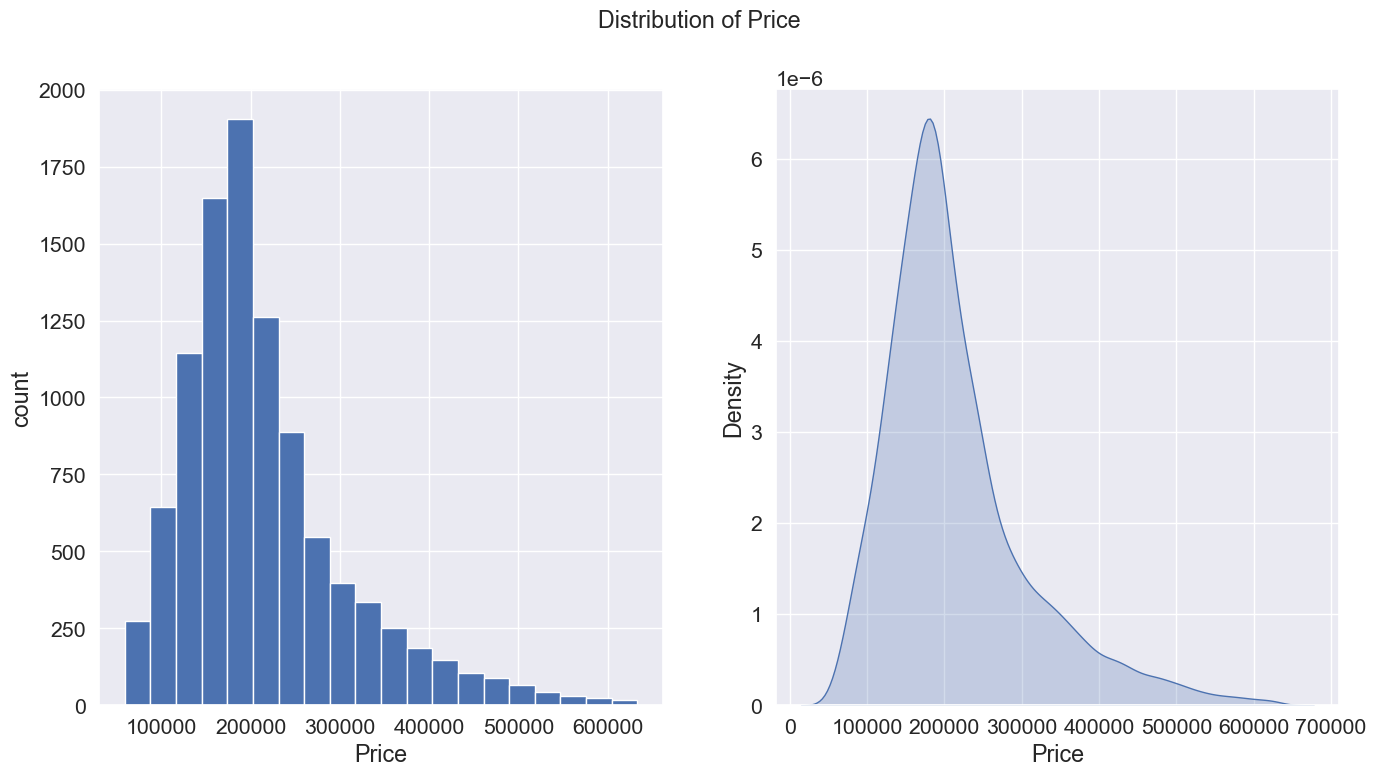

In [1287]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

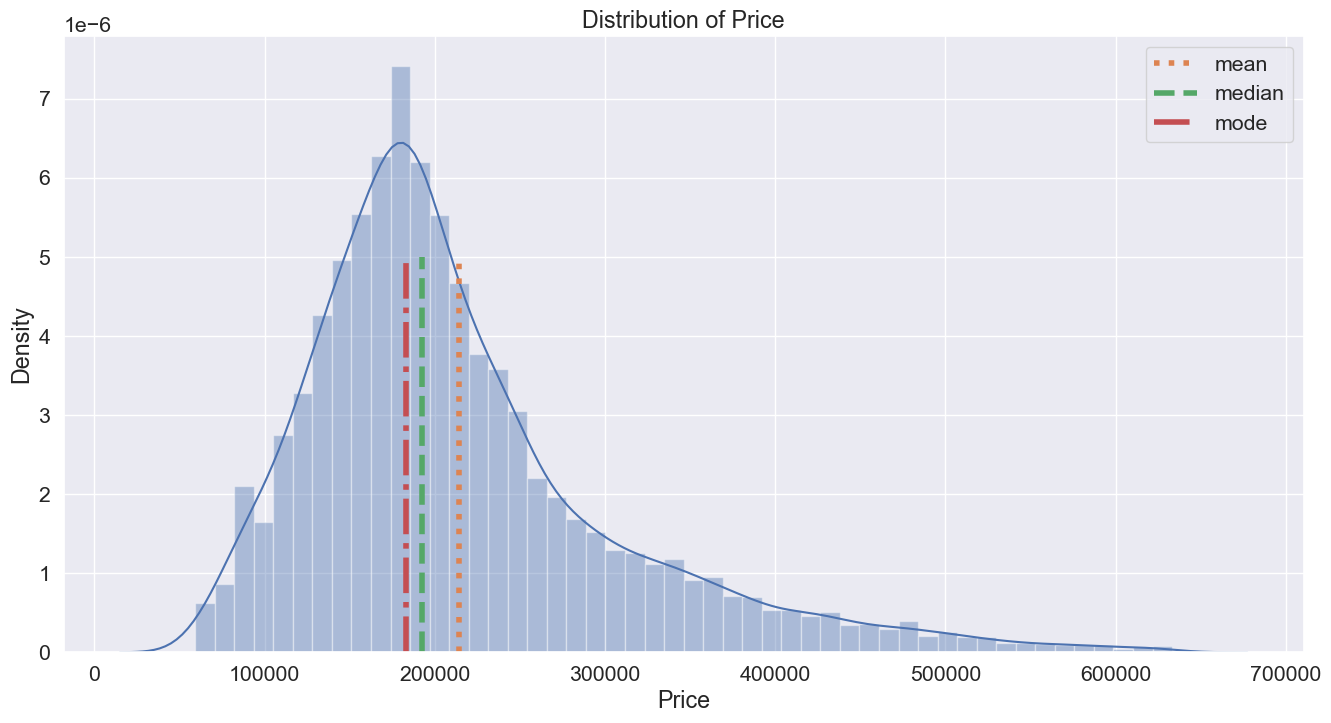

In [1288]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

Распределение более менее симметричное (немного длинный хвост вправо, но мы не можем исключать того факта, что цены на недавижимость могут быть сильно высокими по сравнению со среднерыночными), метрики центральной тенденции располагаются логично.

### 2.2 Распределение признаков

**Количественные признаки**

In [1289]:
df.dtypes

DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

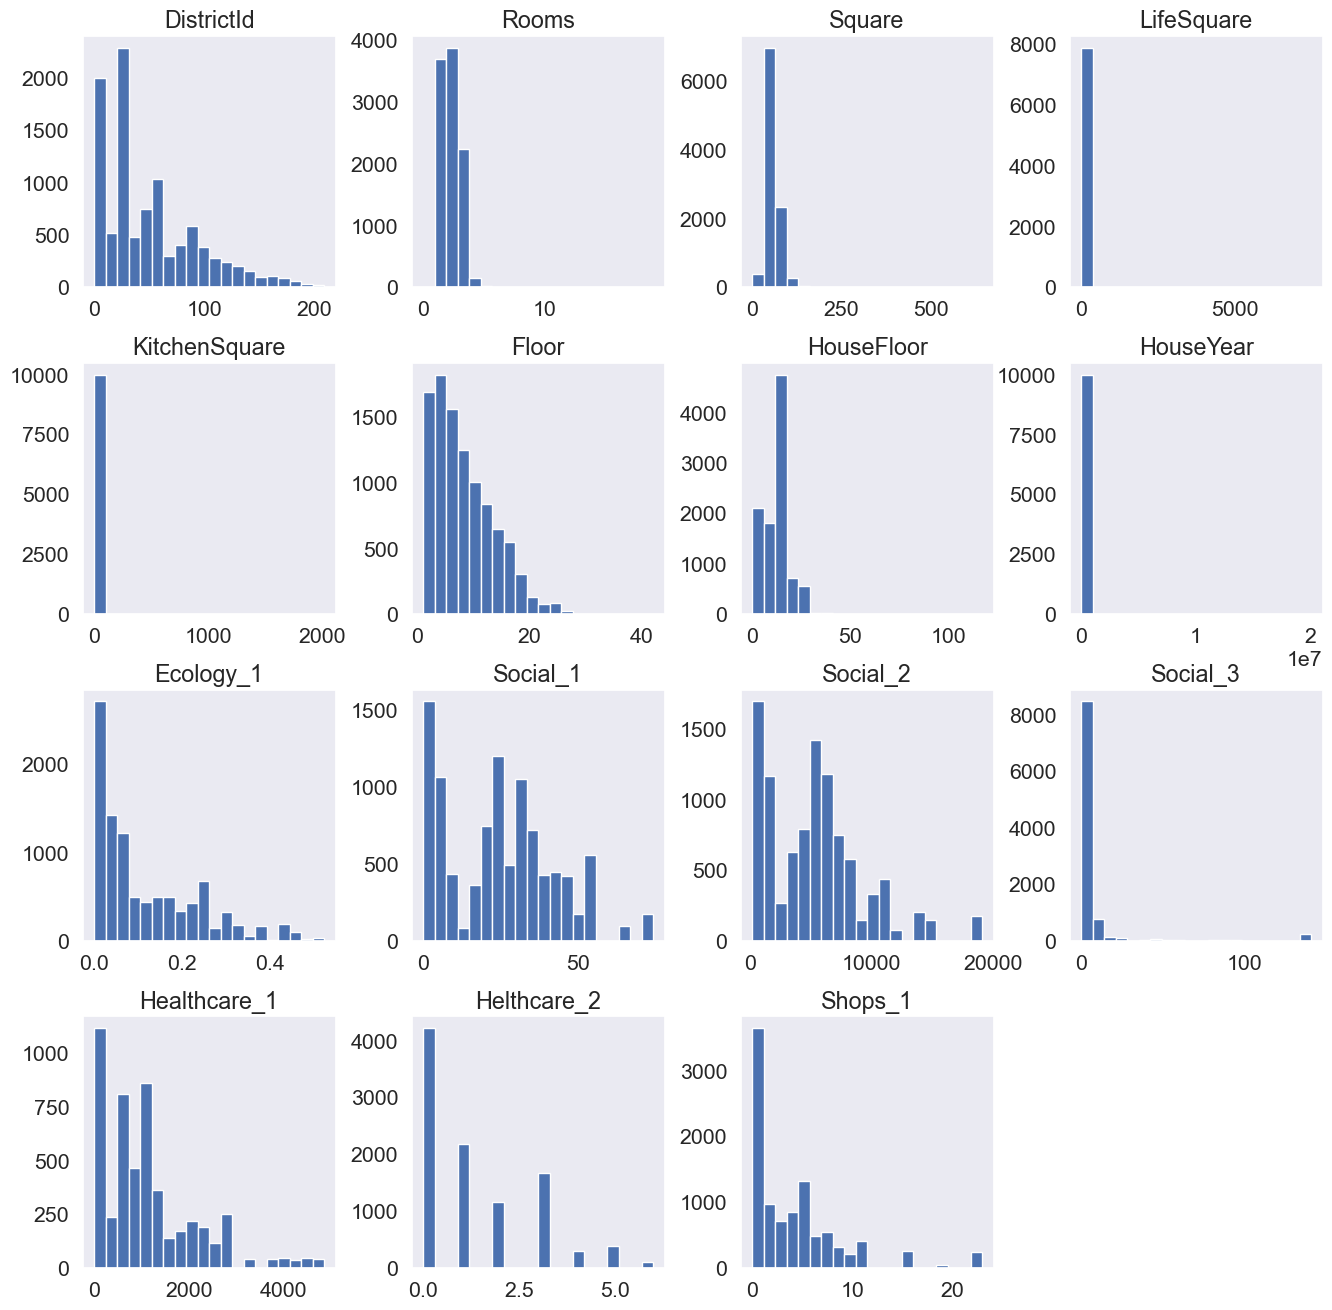

In [1290]:
df_num_features = df.select_dtypes(include=['number']).drop('Price', axis=1)
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

**Обработка выбросов**

1. Rooms

Можно предположить, что значения > 6 комнат - выбросы. Заменим их на медианное значение.

In [1291]:
df['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839523
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

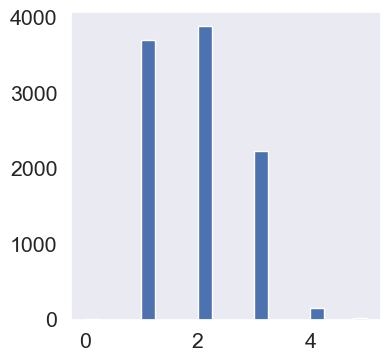

In [1292]:
create_hist('Rooms', 6)  
#df.loc[df['Rooms'] < 6 , 'Rooms'].hist(figsize=(4, 4), bins=20, grid=False);

In [1293]:
change_to_median('Rooms', 6)
#df.loc[df['Rooms'] > 6, 'Rooms'] = df['Rooms'].median()

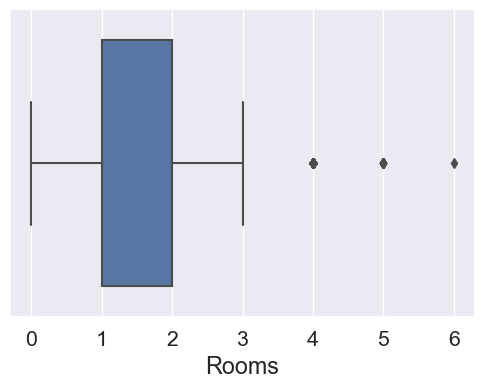

In [1294]:
# 4-6 комнат представлены, как выбросы. Но допустим тот факт, что квартиры могут быть до 6 комнат.
sns.boxplot(df['Rooms']);

2. Square

In [1295]:
df['Square'].describe()

count    10000.000000
mean        56.315712
std         21.058718
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

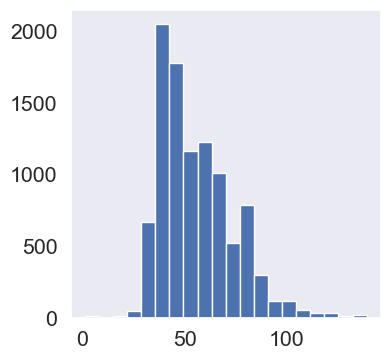

In [1296]:
create_hist('Square', 140)
#df.loc[df['Square'] < 140, 'Square'].hist(figsize=(4, 4), bins=20, grid=False);

In [1297]:
change_to_median('Square', 140)
#df.loc[df['Square'] > 140, 'Square'] = df['Square'].median()

3. LifeSquare

In [1298]:
df['LifeSquare'].describe()

count    7887.000000
mean       37.199596
std        86.241112
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

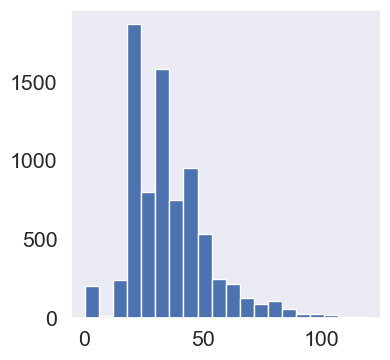

In [1299]:
create_hist('LifeSquare', 120) 
#df.loc[df['LifeSquare'] < 120, 'LifeSquare'].hist(figsize=(4, 4), bins=20, grid=False);

In [1300]:
change_to_median('LifeSquare', 110)
#df.loc[df['LifeSquare'] > 110, 'LifeSquare'] = df['LifeSquare'].median()

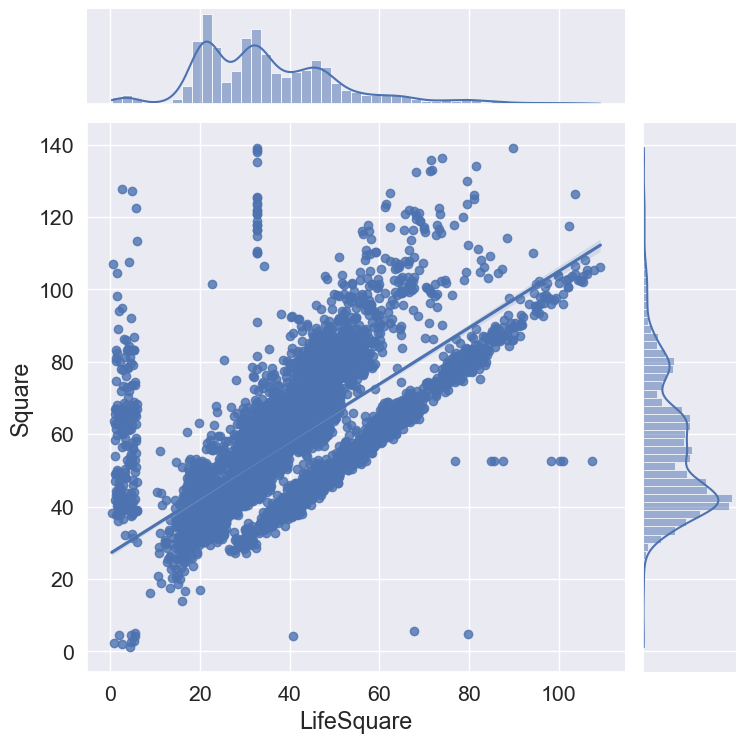

In [1301]:
create_jointplot('LifeSquare', 'Square')

4. KitchenSquare

In [1302]:
df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.561113
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

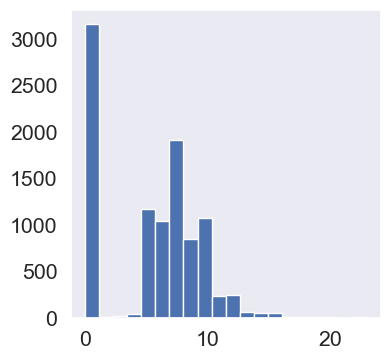

In [1303]:
create_hist('KitchenSquare', 25)
#df.loc[df['KitchenSquare'] < 25, 'KitchenSquare'].hist(figsize=(4, 4), bins = 20, grid=False);

In [1304]:
change_to_median('KitchenSquare', 25)
#df.loc[df['KitchenSquare'] > 25, 'KitchenSquare'] = df['KitchenSquare'].median()

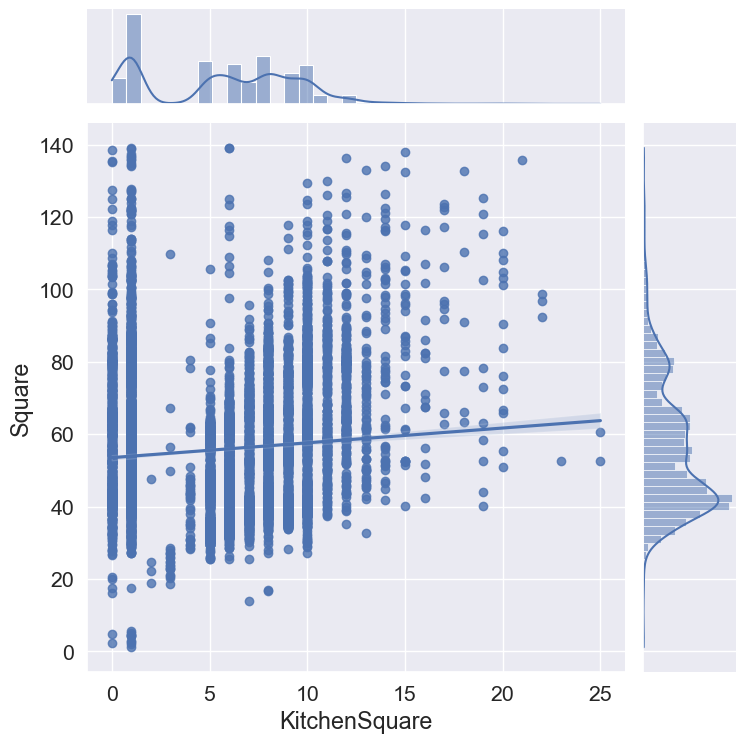

In [1305]:
create_jointplot('KitchenSquare', 'Square')

# grid_1 = sns.jointplot(df['Square'], df['KitchenSquare'], kind='reg')
# grid_1.fig.set_figwidth(8)
# grid_1.fig.set_figheight(8)

# plt.show()

5. Floor, HouseFloor

In [1306]:
change_to_median('HouseFloor', 50)
change_to_median('Floor', 50)

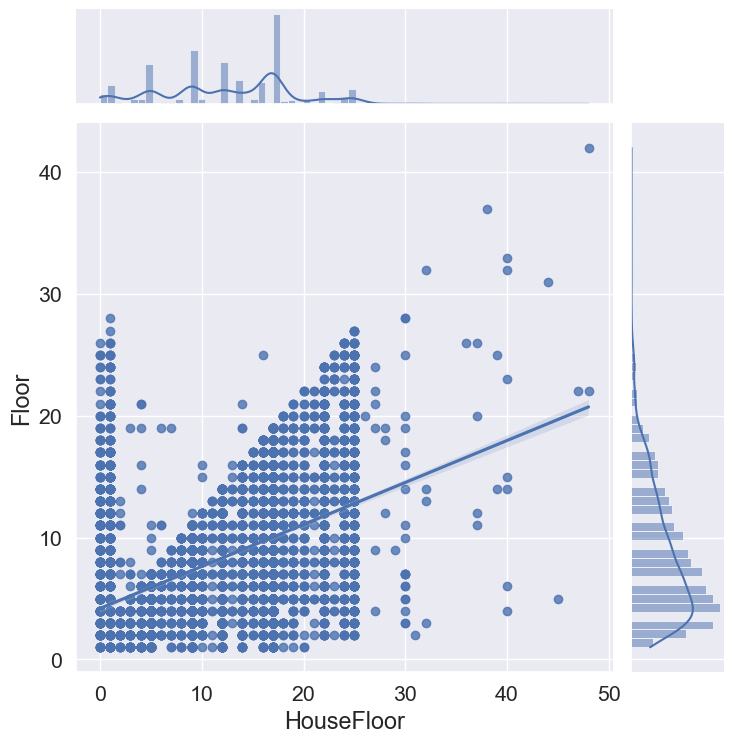

In [1307]:
create_jointplot('HouseFloor', 'Floor')

6. HouseYear

In [1308]:
change_to_median('HouseYear', 2023)
#df.loc[df['HouseYear']>2023] = df['HouseYear'].median()

7. Social_3

In [1309]:
df['Social_3'].describe()

count    10000.000000
mean         8.039200
std         23.831875
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

In [1310]:
change_to_median('Social_3', 93)

Посмотрим на сводку после обработки выбросов

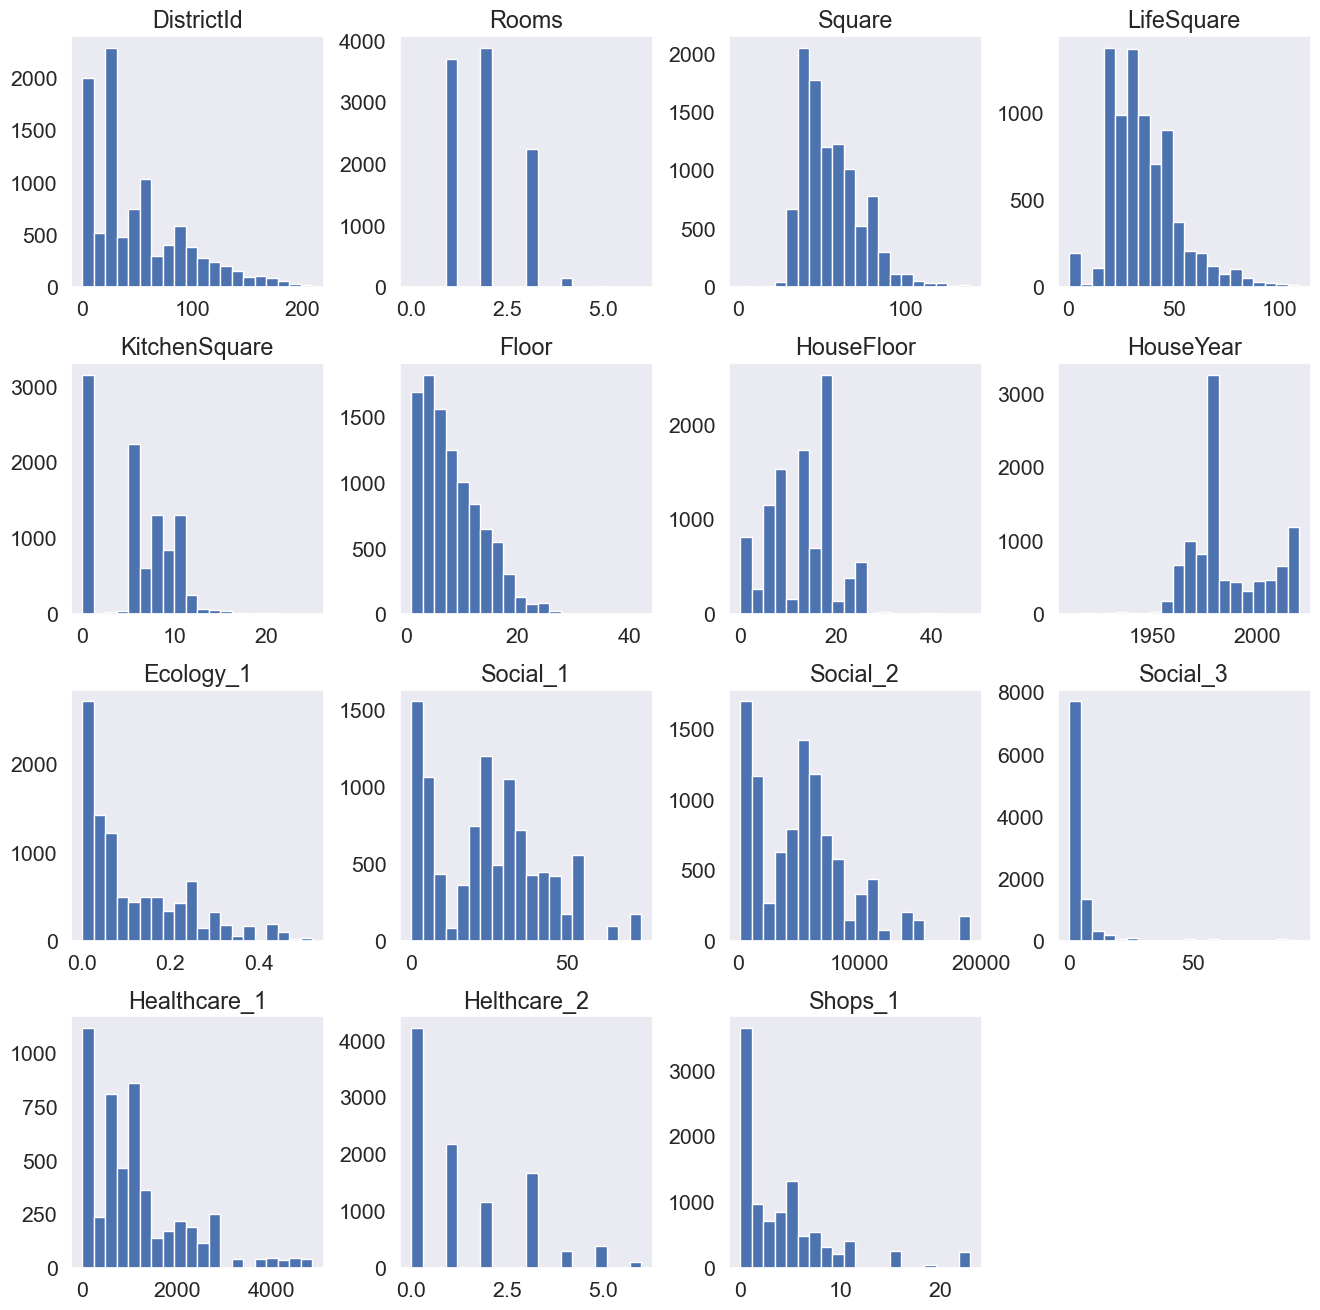

In [1311]:
df_num_features = df.select_dtypes(include=['number']).drop('Price', axis=1)
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

**Категориальные признаки**

In [1312]:
cat_features = df.select_dtypes(include='category').columns
cat_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

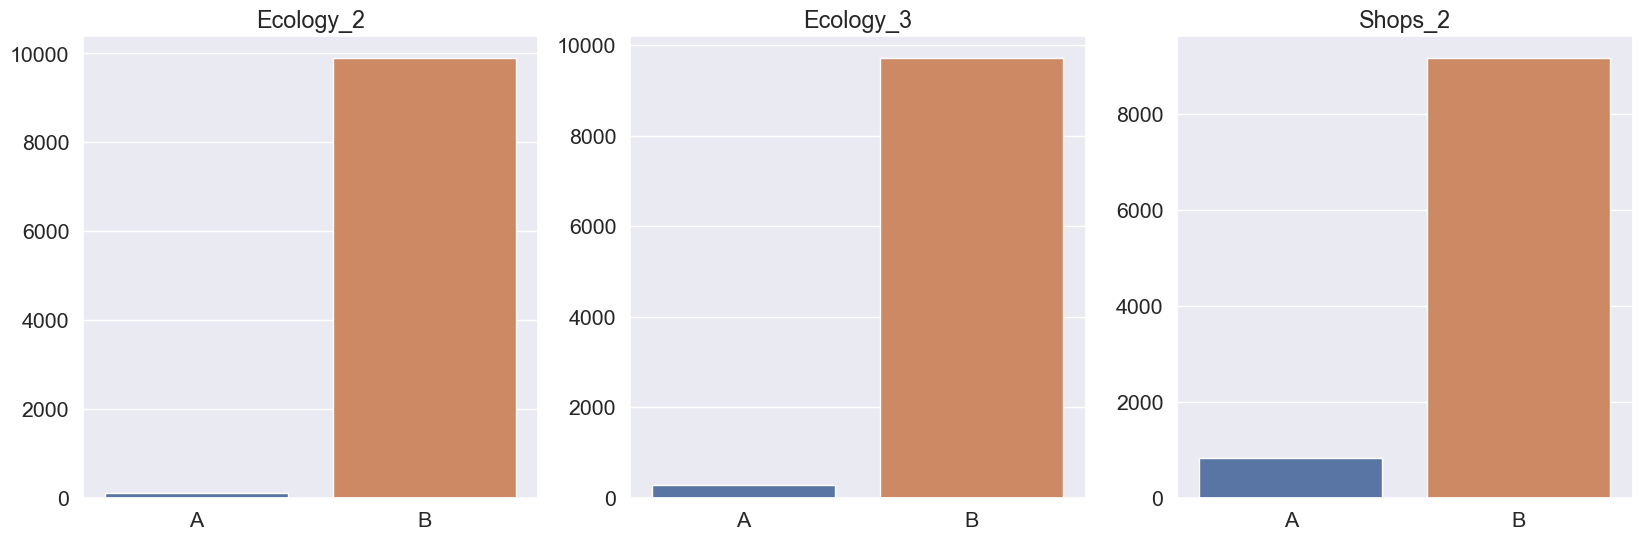

In [1313]:
plt.figure(figsize=(20,6)) 

for i, colname in enumerate(cat_features):
    counts = df[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

**Матрица корелляций**

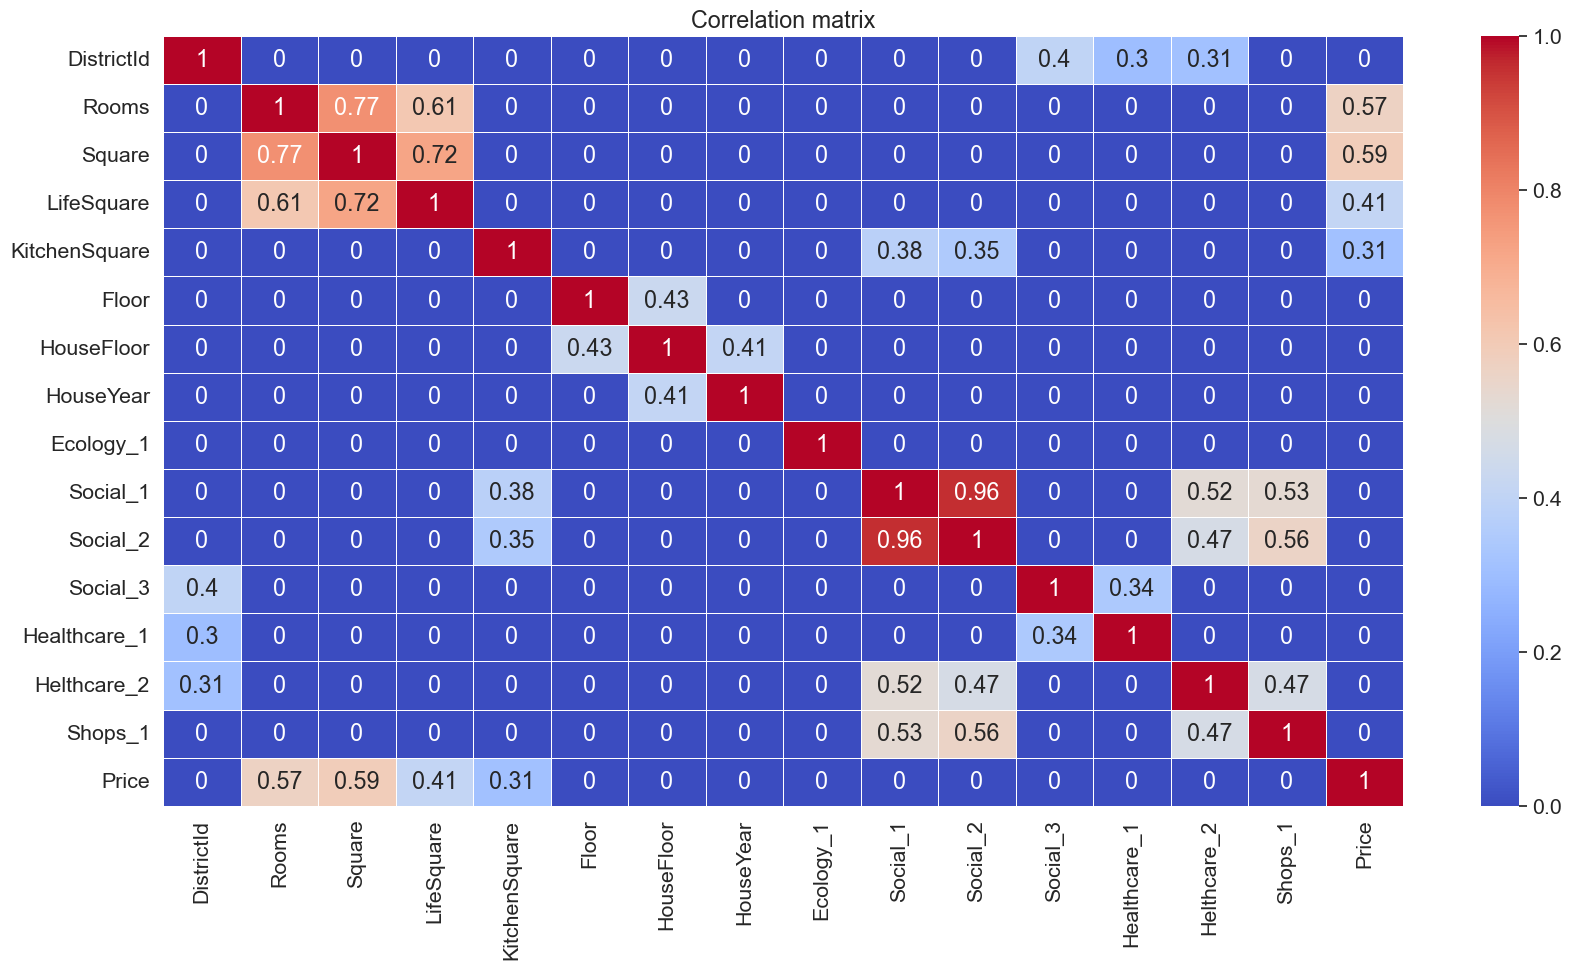

In [1314]:
plt.figure(figsize = (20,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

На таргет ('Price') влияют признаки Rooms, Square, LifeSquare, KitchenSquare

### 3.3 Анализ зависимостей таргета от признаков

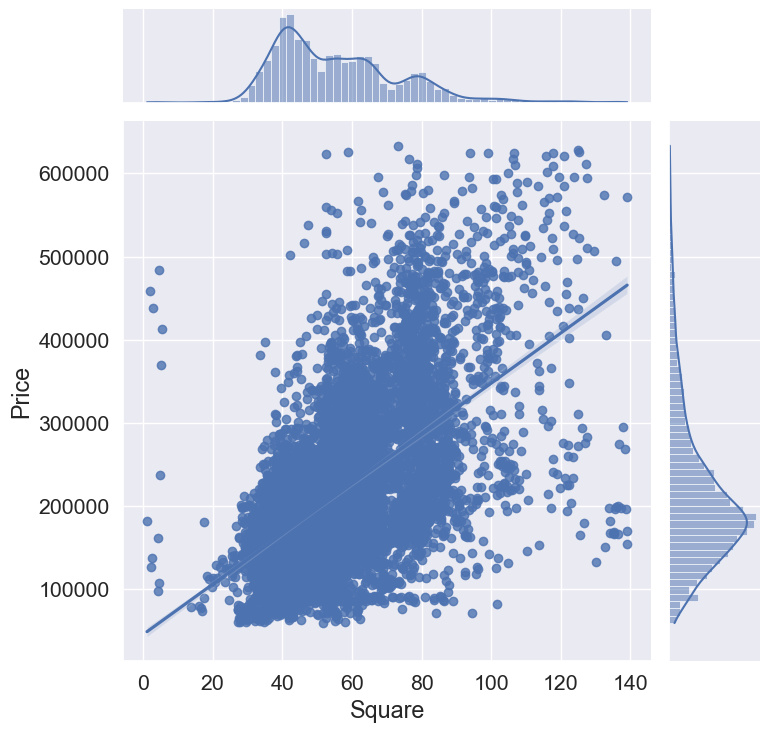

In [1315]:
# Чем больше общая площадь квартиры, тем выше цена.

create_jointplot('Square', 'Price')

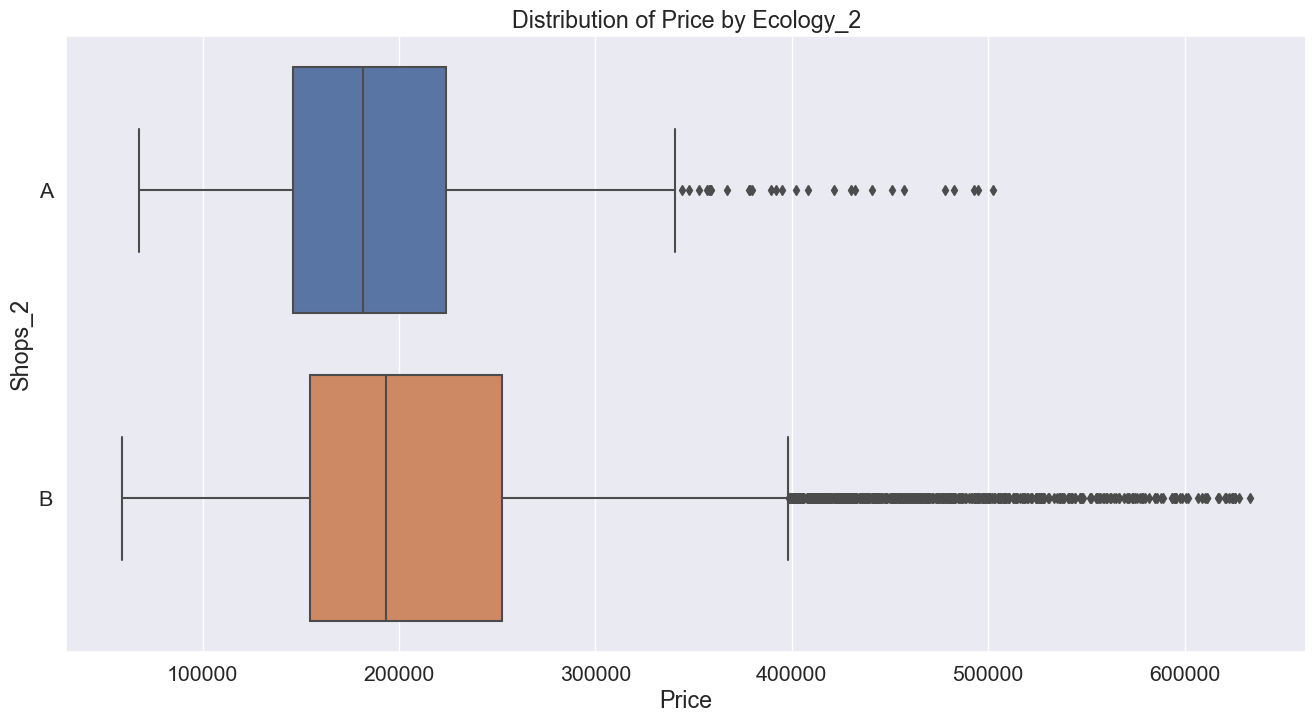

In [1316]:
create_boxplot_objfeature_price('Ecology_2')

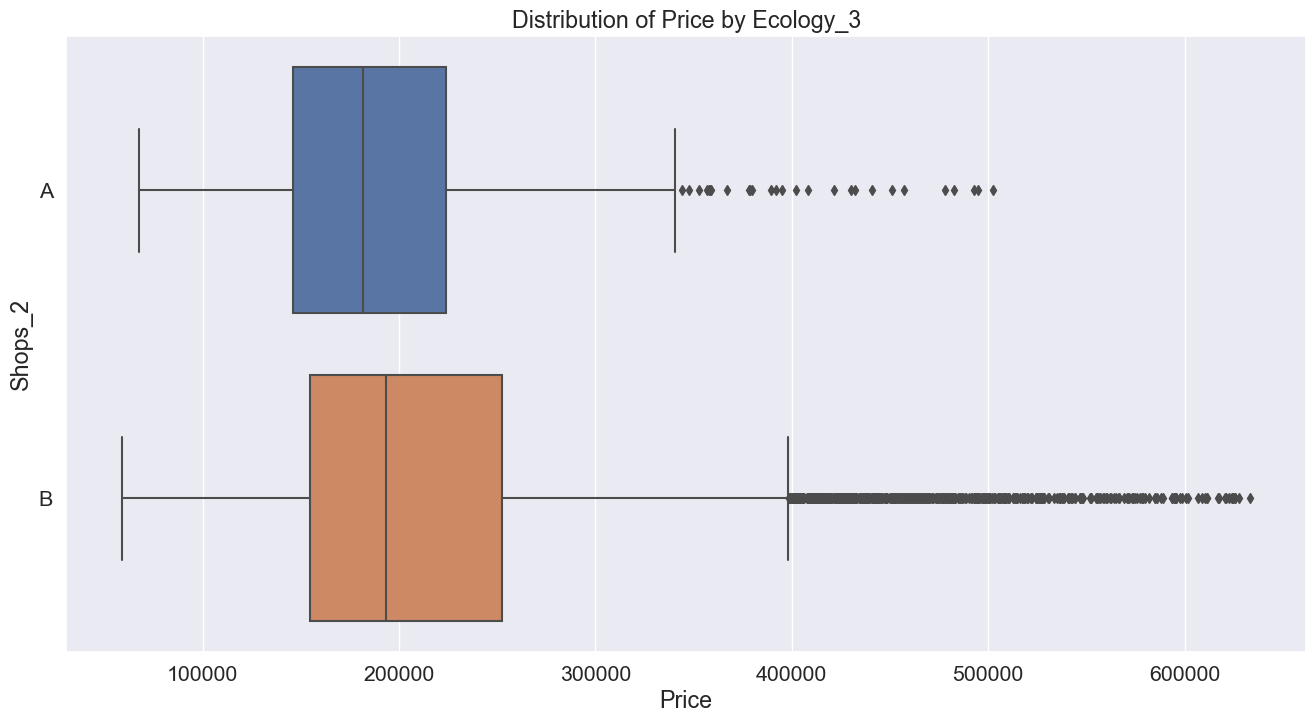

In [1317]:
create_boxplot_objfeature_price('Ecology_3')

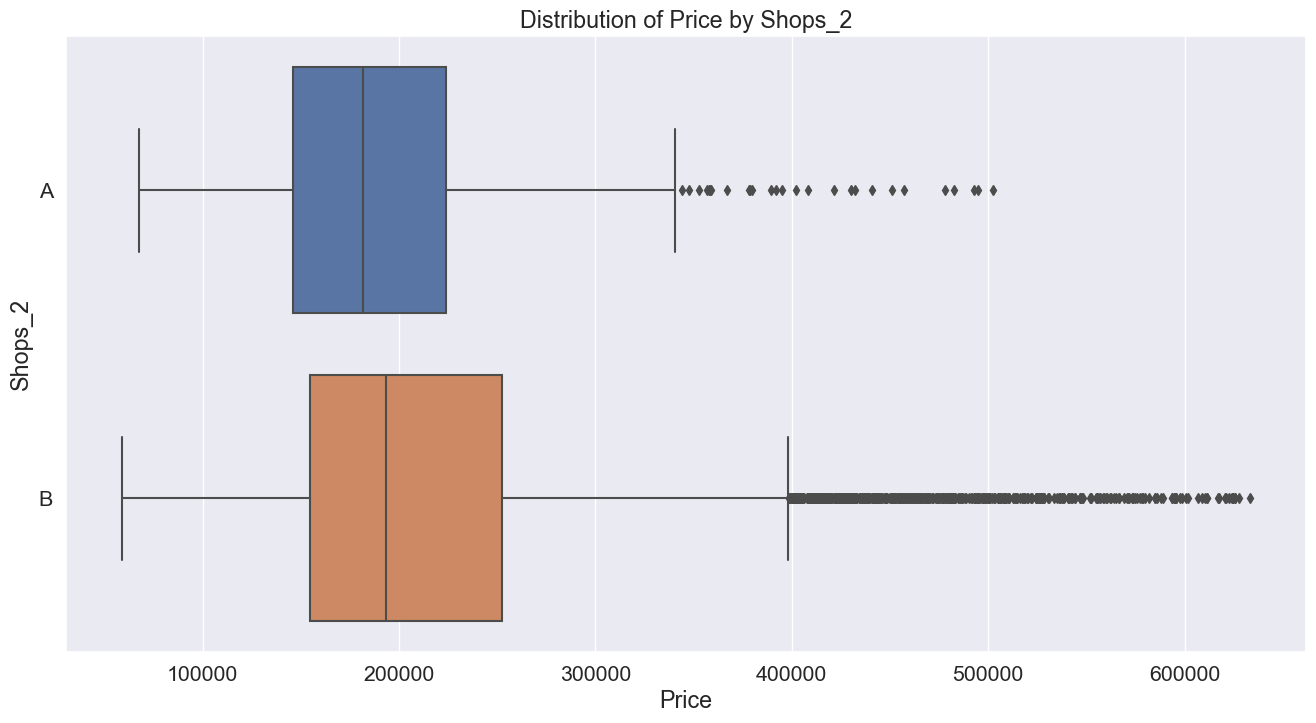

In [1318]:
create_boxplot_objfeature_price('Shops_2')

### 3. Обработка пропусков, генерация новых признаков (feature engineering).
**Обработка пропусков**

Необходимо поработать с пропусками, т.к. некоторые модели машинного обучения не принимат данные с пропусками.

Получим число и процент пропущенных значений от общего количества строк датасета для признаков, имеющих таковые.

In [1319]:
#Получаем число пропущенных значений в каждом столбце
n_misval = df.isna().sum()

#Исключаем из вывода столбцы с 0 пропусками
n_misval = n_misval[n_misval > 0]
n_misval

#Получаем процентное соотношение пропусков к количеству строк датасета
percentage_misval = n_misval * 100 / df.shape[0]

#Соединяем число и процент пропусков в датафрейм
pd.concat([n_misval, percentage_misval], axis=1,
          keys=['Пропуски', 'Процент']).sort_values(by='Пропуски', ascending=False)

,Пропуски,Процент
Healthcare_1,4798,47.98
LifeSquare,2113,21.13


In [1320]:
fill_nan_with_median('Healthcare_1')

Кол-во строк с единицами 4798
Кол-во пропусков после подстановки 0


In [1321]:
fill_nan_with_median('LifeSquare')

Кол-во строк с единицами 2113
Кол-во пропусков после подстановки 0


In [1322]:
df.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan,LifeSquare_nan
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,...,33,7976,5,900.0,0,11,B,184966.937500,1,0
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,...,46,10309,1,240.0,1,16,B,300009.437500,0,0
2,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,...,34,7759,0,229.0,1,3,B,220925.906250,0,0
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,...,23,5735,3,1084.0,0,5,B,175616.234375,0,0
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,...,35,5776,1,2078.0,2,4,B,150226.531250,0,0
5,59,3.0,80.384476,46.683720,12.0,5,17.0,2011,0.309479,B,...,35,7715,4,990.0,0,6,B,215898.453125,0,0
6,154,2.0,62.254112,37.160378,7.0,3,5.0,1960,0.460556,B,...,20,4386,14,900.0,1,5,B,296021.218750,1,0
7,74,2.0,80.312927,32.781261,0.0,14,0.0,1977,0.075779,B,...,6,1437,3,900.0,0,2,B,221244.156250,1,1
8,1,2.0,64.511436,32.781261,1.0,9,17.0,1977,0.007122,B,...,1,264,0,900.0,0,1,B,229102.796875,1,1
9,23,1.0,46.461411,18.915552,8.0,13,17.0,2014,0.075779,B,...,6,1437,3,900.0,0,2,B,95380.218750,1,0


Проверим, что в датасете не осталось пропусков.

In [1323]:
df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Healthcare_1_nan    0
LifeSquare_nan      0
dtype: int64

**Feature Engineering**

1. Feature binarization 

Трансформация категориальных признаков, содержащих 2 типа значений (A и B) в бинарные, где A = 1, B = 0.

(Ecology_2, Ecology_3, Shops_2)

In [1324]:
df['Ecology_2'] = df['Ecology_2'].map({'A': 1, 'B': 0})
df['Ecology_3'] = df['Ecology_3'].map({'A': 1, 'B': 0})
df['Shops_2'] = df['Shops_2'].map({'A': 1, 'B': 0})

2. Создание признака: HouseAge (возраст дома)

In [1325]:
HouseAge_list = []
n=0

while n < 10000:
    house_age = 2023 - (df.loc[n, 'HouseYear'])
    HouseAge_list.append(house_age)
    n+=1

df.insert(7, 'HouseAge', HouseAge_list)

In [1326]:
df.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseAge,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan,LifeSquare_nan
0,35,2.0,47.981560,29.442751,6.0,7,9.0,54,1969,0.089040,...,33,7976,5,900.0,0,11,0,184966.937500,1,0
1,41,3.0,65.683640,40.049541,8.0,7,9.0,45,1978,0.000070,...,46,10309,1,240.0,1,16,0,300009.437500,0,0
2,53,2.0,44.947952,29.197611,0.0,8,12.0,55,1968,0.049637,...,34,7759,0,229.0,1,3,0,220925.906250,0,0
3,58,2.0,53.352982,52.731510,9.0,8,17.0,46,1977,0.437885,...,23,5735,3,1084.0,0,5,0,175616.234375,0,0
4,99,1.0,39.649193,23.776169,7.0,11,12.0,47,1976,0.012339,...,35,5776,1,2078.0,2,4,0,150226.531250,0,0
5,59,3.0,80.384476,46.683720,12.0,5,17.0,12,2011,0.309479,...,35,7715,4,990.0,0,6,0,215898.453125,0,0
6,154,2.0,62.254112,37.160378,7.0,3,5.0,63,1960,0.460556,...,20,4386,14,900.0,1,5,0,296021.218750,1,0
7,74,2.0,80.312927,32.781261,0.0,14,0.0,46,1977,0.075779,...,6,1437,3,900.0,0,2,0,221244.156250,1,1
8,1,2.0,64.511436,32.781261,1.0,9,17.0,46,1977,0.007122,...,1,264,0,900.0,0,1,0,229102.796875,1,1
9,23,1.0,46.461411,18.915552,8.0,13,17.0,9,2014,0.075779,...,6,1437,3,900.0,0,2,0,95380.218750,1,0


In [1327]:
df['HouseAge'].describe()

count    10000.000000
mean        38.136200
std         18.409979
min          3.000000
25%         22.000000
50%         46.000000
75%         49.000000
max        113.000000
Name: HouseAge, dtype: float64

3. Feature discretization

Создание категорий для значений HouseYear (1910 - 2020 гг.) и HouseAge

In [1328]:
df['HouseYear'].describe()

count    10000.000000
mean      1984.863800
std         18.409979
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64

In [1329]:
def age_to_category(feature):

    df[f'{feature}_category'] = 0

    df.loc[df[feature] < 5, f'{feature}_category'] = 1  
    df.loc[(df[feature] > 5) & (df[feature] <= 15), f'{feature}_category'] = 2
    df.loc[(df[feature] > 15) & (df[feature] <= 30), f'{feature}_category'] = 3
    df.loc[df[feature] > 30, f'{feature}_category'] = 4

age_to_category('HouseAge')

In [1330]:
def date_to_category(df):

    df['HouseYear_category'] = 0

    df.loc[df['HouseYear'] > 2018, 'HouseYear_category'] = 1  
    df.loc[(df['HouseYear'] < 2018) & (df['HouseYear'] >= 2008), 'HouseYear_category'] = 2
    df.loc[(df['HouseYear'] < 2008) & (df['HouseYear'] >= 1993), 'HouseYear_category'] = 3
    df.loc[df['HouseYear'] < 1993, 'HouseYear_category'] = 4

    return df

In [1331]:
df = date_to_category(df)
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseAge,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan,LifeSquare_nan,HouseAge_category,HouseYear_category
0,35,2.0,47.981560,29.442751,6.0,7,9.0,54,1969,0.089040,...,5,900.0,0,11,0,184966.937500,1,0,4,4
1,41,3.0,65.683640,40.049541,8.0,7,9.0,45,1978,0.000070,...,1,240.0,1,16,0,300009.437500,0,0,4,4
2,53,2.0,44.947952,29.197611,0.0,8,12.0,55,1968,0.049637,...,0,229.0,1,3,0,220925.906250,0,0,4,4
3,58,2.0,53.352982,52.731510,9.0,8,17.0,46,1977,0.437885,...,3,1084.0,0,5,0,175616.234375,0,0,4,4
4,99,1.0,39.649193,23.776169,7.0,11,12.0,47,1976,0.012339,...,1,2078.0,2,4,0,150226.531250,0,0,4,4


4. Доля комнат (Rooms) на площадь (Square)

In [1332]:
RoomShare_list = df['Rooms'] / df['Square'] * 100

df.insert(4, 'RoomShare', RoomShare_list)

In [1333]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,RoomShare,KitchenSquare,Floor,HouseFloor,HouseAge,HouseYear,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan,LifeSquare_nan,HouseAge_category,HouseYear_category
0,35,2.0,47.981560,29.442751,4.168268,6.0,7,9.0,54,1969,...,5,900.0,0,11,0,184966.937500,1,0,4,4
1,41,3.0,65.683640,40.049541,4.567348,8.0,7,9.0,45,1978,...,1,240.0,1,16,0,300009.437500,0,0,4,4
2,53,2.0,44.947952,29.197611,4.449591,0.0,8,12.0,55,1968,...,0,229.0,1,3,0,220925.906250,0,0,4,4
3,58,2.0,53.352982,52.731510,3.748619,9.0,8,17.0,46,1977,...,3,1084.0,0,5,0,175616.234375,0,0,4,4
4,99,1.0,39.649193,23.776169,2.522120,7.0,11,12.0,47,1976,...,1,2078.0,2,4,0,150226.531250,0,0,4,4


5. DisctrictId

DistrictSize, IsDistrictLarge

In [1334]:
district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [1335]:
df = df.merge(district_size, on='DistrictId', how='left')
df.head()

,DistrictId,Rooms,Square,LifeSquare,RoomShare,KitchenSquare,Floor,HouseFloor,HouseAge,HouseYear,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan,LifeSquare_nan,HouseAge_category,HouseYear_category,DistrictSize
0,35,2.0,47.981560,29.442751,4.168268,6.0,7,9.0,54,1969,...,900.0,0,11,0,184966.937500,1,0,4,4,22
1,41,3.0,65.683640,40.049541,4.567348,8.0,7,9.0,45,1978,...,240.0,1,16,0,300009.437500,0,0,4,4,87
2,53,2.0,44.947952,29.197611,4.449591,0.0,8,12.0,55,1968,...,229.0,1,3,0,220925.906250,0,0,4,4,174
3,58,2.0,53.352982,52.731510,3.748619,9.0,8,17.0,46,1977,...,1084.0,0,5,0,175616.234375,0,0,4,4,179
4,99,1.0,39.649193,23.776169,2.522120,7.0,11,12.0,47,1976,...,2078.0,2,4,0,150226.531250,0,0,4,4,97


In [1336]:
(df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [1337]:
df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)
df.head()

,DistrictId,Rooms,Square,LifeSquare,RoomShare,KitchenSquare,Floor,HouseFloor,HouseAge,HouseYear,...,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_1_nan,LifeSquare_nan,HouseAge_category,HouseYear_category,DistrictSize,IsDistrictLarge
0,35,2.0,47.981560,29.442751,4.168268,6.0,7,9.0,54,1969,...,0,11,0,184966.937500,1,0,4,4,22,0
1,41,3.0,65.683640,40.049541,4.567348,8.0,7,9.0,45,1978,...,1,16,0,300009.437500,0,0,4,4,87,0
2,53,2.0,44.947952,29.197611,4.449591,0.0,8,12.0,55,1968,...,1,3,0,220925.906250,0,0,4,4,174,1
3,58,2.0,53.352982,52.731510,3.748619,9.0,8,17.0,46,1977,...,0,5,0,175616.234375,0,0,4,4,179,1
4,99,1.0,39.649193,23.776169,2.522120,7.0,11,12.0,47,1976,...,2,4,0,150226.531250,0,0,4,4,97,0


6. MedPriceByDistrict

In [1338]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df.head()

,DistrictId,Rooms,Square,LifeSquare,RoomShare,KitchenSquare,Floor,HouseFloor,HouseAge,HouseYear,...,Shops_1,Shops_2,Price,Healthcare_1_nan,LifeSquare_nan,HouseAge_category,HouseYear_category,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,35,2.0,47.981560,29.442751,4.168268,6.0,7,9.0,54,1969,...,11,0,184966.937500,1,0,4,4,22,0,207786.125000
1,41,3.0,65.683640,40.049541,4.567348,8.0,7,9.0,45,1978,...,16,0,300009.437500,0,0,4,4,87,0,300009.437500
2,53,2.0,44.947952,29.197611,4.449591,0.0,8,12.0,55,1968,...,3,0,220925.906250,0,0,4,4,174,1,263206.218750
3,58,2.0,53.352982,52.731510,3.748619,9.0,8,17.0,46,1977,...,5,0,175616.234375,0,0,4,4,179,1,166809.671875
4,99,1.0,39.649193,23.776169,2.522120,7.0,11,12.0,47,1976,...,4,0,150226.531250,0,0,4,4,97,0,158539.062500


#### Сохранение результатов

In [1339]:
df.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8', sep=',')

### 4. Обработка тестового датасета (test.csv)

In [1340]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
#         self.medians = None
#         self.rooms_median = None
#         self.square_median = None
#         self.lifesquare_median = None
#         self.kitchensquare_median = None
#         self.housefloor_median = None
#         self.social3_median = None
        
        
    def fit(self, ds):
        """Сохранение статистик"""
        
        # Расчет медиан (берем медианы из train.csv = df, ds - test.csv)
        self.medians = ds.median()
#         self.medians = df[['LifeSquare', 'Healthcare_1']].median()
#         self.rooms_median = df['Rooms'].median()
#         self.square_median = df['Square'].median()
        
    def fill_nan_with_median(self, ds, feature):
            """Заполнить пропуск NaN медианой с созданием фиктивного столбца"""
        
            # Создаем фиктивный признак с флагом (True), что в оригинальном признаке идет подстановка значений на место пропуска
            ds[f'{feature}_nan'] = 0
            ds.loc[ds[feature].isna(), f'{feature}_nan'] = 1

            # Сверяем кол-во строк True фиктивного признака с кол-вом пропусков оригинального столбца
            print('Кол-во строк с единицами {}'.format(ds[ds[f'{feature}_nan'] == 1].shape[0]))

            # Подставляем на место пропусков медиану
            ds[feature] = ds[feature].fillna(self.medians[feature])

            # Удостоверяемся, что все пропуски заполнены.
            print('Кол-во пропусков после подстановки {}'.format(ds[feature].isna().sum()))
        
        
        
    def transform(self, ds):
        """Трансформация данных"""
        
        # Выбросы
        ds.loc[ds['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        ds.loc[ds['Square'] > 140, 'Square'] = self.medians['Square']
        ds.loc[ds['LifeSquare'] > 110, 'LifeSquare'] = self.medians['LifeSquare']
        ds.loc[ds['KitchenSquare'] > 25, 'KitchenSquare'] = self.medians['KitchenSquare']
        ds.loc[ds['HouseFloor'] > 50, 'HouseFloor'] = self.medians['HouseFloor']
        ds.loc[ds['Floor'] > 50, 'Floor'] = self.medians['Floor']
        ds.loc[ds['HouseYear'] > 2023, 'HouseYear'] = self.medians['HouseYear']
        ds.loc[ds['Social_3'] > 93, 'Social_3'] = self.medians['Social_3']
    
        return ds

In [1341]:
class FeatureGenerator:
    
    def __init__(self):
        self.binary_to_numbers = {'A': 1, 'B': 0}
        self.district_size = None
        self.med_price_by_district = None

        
    def transform(self, ds, y=None):
        
        ds = ds.copy()
        
        #HouseAge
        HouseAge_list = []
        n=0

        while n < 5000:
            house_age = 2023 - (ds.loc[n, 'HouseYear'])
            HouseAge_list.append(house_age)
            n+=1
        ds['HouseAge'] = HouseAge_list
        ds['HouseAge'] = ds['HouseAge'].astype('float32')
        
        #Binary_to_numbers
        ds['Ecology_2'] = ds['Ecology_2'].map(self.binary_to_numbers)
        ds['Ecology_3'] = ds['Ecology_3'].map(self.binary_to_numbers)
        ds['Shops_2'] = ds['Shops_2'].map(self.binary_to_numbers)
        
        ds['Ecology_2'] = ds['Ecology_2'].astype('int8')
        ds['Ecology_3'] = ds['Ecology_3'].astype('int8')
        ds['Shops_2'] = ds['Shops_2'].astype('int8')
        
        #HouseAge_category
        ds['HouseAge_category'] = 0
        ds.loc[ds['HouseAge'] < 5, 'HouseAge_category'] = 1  
        ds.loc[(ds['HouseAge'] > 5) & (ds['HouseAge'] <= 15), 'HouseAge_category'] = 2
        ds.loc[(ds['HouseAge'] > 15) & (ds['HouseAge'] <= 30), 'HouseAge_category'] = 3
        ds.loc[ds['HouseAge'] > 30, 'HouseAge_category'] = 4
        
        #HouseYear_category
        ds['HouseYear_category'] = 0
        ds.loc[ds['HouseYear'] > 2018, 'HouseYear_category'] = 1  
        ds.loc[(ds['HouseYear'] < 2018) & (ds['HouseYear'] >= 2008), 'HouseYear_category'] = 2
        ds.loc[(ds['HouseYear'] < 2008) & (ds['HouseYear'] >= 1993), 'HouseYear_category'] = 3
        ds.loc[ds['HouseYear'] < 1993, 'HouseYear_category'] = 4
        
        #Доля комнат (Rooms) на площадь (Square)
        RoomShare_list = ds['Rooms'] / ds['Square'] * 100
        ds['RoomShare'] = RoomShare_list

        #DisctictSize
        self.district_size = ds['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        ds = ds.merge(self.district_size, on='DistrictId', how='left')
        ds['DistrictSize'] = ds['DistrictSize'].astype('float32')
        
        #IsDisctrictLarge
        ds['IsDistrictLarge'] = (ds['DistrictSize'] > 100).astype(int)
        
        #MedPriceByDistrict
        if y is not None:
            ds['Price'] = y[:5000]
            
            self.med_price_by_district = ds.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
            ds = ds.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            ds = ds.drop(columns='Price')
            
        
        return ds

In [1342]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [1343]:
preprocessor = DataPipeline()
preprocessor.fit(df)

preprocessor.fill_nan_with_median(test_df, 'LifeSquare')
preprocessor.fill_nan_with_median(test_df, 'Healthcare_1')

test_df = preprocessor.transform(test_df)


Кол-во строк с единицами 1041
Кол-во пропусков после подстановки 0
Кол-во строк с единицами 2377
Кол-во пропусков после подстановки 0


In [1344]:
fg = FeatureGenerator()
test_df = fg.transform(test_df, df['Price'].to_numpy())

df.shape, test_df.shape

((10000, 28), (5000, 28))

In [1345]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,LifeSquare_nan,Healthcare_1_nan,HouseAge,HouseAge_category,HouseYear_category,RoomShare,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,0,0,1,51.0,4,4,4.009411,91.0,0,173145.859375
1,15856,74,2.0,69.263183,32.781261,1.0,6,1.0,1977,0.075779,...,0,1,1,46.0,4,4,2.887537,61.0,0,199566.078125
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,0,0,0,114.0,4,4,7.354121,2.0,0,220925.906250
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,0,0,1,16.0,3,3,2.737978,49.0,0,195198.343750
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,1,0,1,6.0,2,2,2.104062,391.0,1,183849.109375


In [1346]:
test_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
LifeSquare_nan        0
Healthcare_1_nan      0
HouseAge              0
HouseAge_category     0
HouseYear_category    0
RoomShare             0
DistrictSize          0
IsDistrictLarge       0
MedPriceByDistrict    0
dtype: int64

### 5. Подготовка данных для подачи в ML-модель

(определить необходимые признаки, стандартизировать значения, сплит данных обучающего датасета (train.csv))

**1. Стандартизация признаков train и test**

Необходимо провести стандартизацию на небинарных числах.

*train.csv*

In [1347]:
df['Ecology_2'] = df['Ecology_2'].astype('int8')
df['Ecology_3'] = df['Ecology_3'].astype('int8')
df['Shops_2'] = df['Shops_2'].astype('int8')

In [1348]:
df['HouseAge'] = df['HouseAge'].astype('float32')
df['DistrictSize'] = df['DistrictSize'].astype('float32')

In [1349]:
# Выбираем все признаки, кроме бинарных и таргета для стандартизации
feature_names_for_stand = df.drop(columns=['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2',
                                           'Price', 'Healthcare_1_nan', 'LifeSquare_nan', 'HouseAge_category',
                                           'HouseYear_category', 'IsDistrictLarge']).columns.to_list()


In [1237]:
# Проводим стандартизацию
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])
stand_features.shape

(10000, 18)

In [1238]:
# Обновляем датасет стандартизованными данными
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df = df.drop(columns='DistrictId')
df.head()

,Rooms,Square,LifeSquare,RoomShare,KitchenSquare,Floor,HouseFloor,HouseAge,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Healthcare_1_nan,LifeSquare_nan,HouseAge_category,HouseYear_category,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,0.138608,-0.434250,-0.380828,0.445969,0.080104,-0.291306,-0.544160,0.861739,-0.861739,-0.250529,...,1.408356,0,184966.937500,1,0,4,4,-0.819047,0,-0.048883
1,1.367406,0.544127,0.345493,0.673043,0.592769,-0.291306,-0.544160,0.372849,-0.372849,-0.998053,...,2.448700,0,300009.437500,0,0,4,4,-0.577393,0,1.156064
2,0.138608,-0.601915,-0.397614,0.606040,-1.457890,-0.100498,-0.088389,0.916060,-0.916060,-0.581588,...,-0.256195,0,220925.906250,0,0,4,4,-0.253948,1,0.675210
3,0.138608,-0.137377,1.213916,0.207192,0.849101,-0.100498,0.671229,0.427170,-0.427170,2.680470,...,0.159943,0,175616.234375,0,0,4,4,-0.235359,1,-0.584262
4,-1.090189,-0.894772,-0.768858,-0.490677,0.336436,0.471924,-0.088389,0.481491,-0.481491,-0.894969,...,-0.048126,0,150226.531250,0,0,4,4,-0.540215,0,-0.692321


In [676]:
# Сохраняем стандартизованный трен. датасет
with open('Scaled_df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [678]:
# with open('Scaled_df.pkl', 'rb') as f:
#     df = pickle.load(f)

*test.csv*

In [1350]:
# Выбираем все признаки, кроме бинарных и таргета для стандартизации
feature_names_for_stand = test_df.drop(columns=['Id','DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2',
                                           'Healthcare_1_nan', 'LifeSquare_nan', 'HouseAge_category',
                                           'HouseYear_category', 'IsDistrictLarge']).columns.to_list()

In [1351]:
stand_features = scaler.transform(test_df[feature_names_for_stand])
stand_features.shape

(5000, 18)

In [1352]:
# Обновляем датасет стандартизованными данными
test_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
test_df = test_df.drop(columns='DistrictId')
test_df.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,LifeSquare_nan,Healthcare_1_nan,HouseAge,HouseAge_category,HouseYear_category,RoomShare,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,725,0.138608,-0.329179,-0.107603,1.488211,0.080104,1.044346,297.681808,-2.054749,0,...,0,0,1,33.263902,4,4,-0.046168,-0.562522,0,-0.501476
1,15856,0.138608,0.741965,-0.152217,-1.356751,0.080104,-1.436150,298.441426,-2.067483,0,...,0,1,1,29.916119,4,4,-0.279595,-0.674054,0,-0.156282
2,5480,-1.090189,-2.334607,-1.304891,4.902166,-0.945226,-0.672921,288.110623,-2.071600,0,...,0,0,0,75.445961,4,4,0.649762,-0.893402,0,0.122796
3,15664,0.138608,0.951071,1.159773,3.195188,4.181422,2.570806,302.999133,-2.066066,0,...,0,0,1,9.829424,3,3,-0.310714,-0.718667,0,-0.213349
4,14275,-1.090189,-0.459367,0.574071,-1.356751,2.899760,1.616769,304.518369,-2.067680,0,...,1,0,1,3.133859,2,2,-0.442612,0.552806,1,-0.361632


In [1353]:
# Сохраняем стандартизованный трен. датасет
with open('Scaled_test_df.pkl', 'wb') as f:
    pickle.dump(test_df, f)

**2. Сплит трен. датасета**

In [1249]:
X = df.drop(columns=['Price'])

In [1250]:
y = df['Price'].to_numpy()

In [681]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [1354]:
X_test = test_df
X_test

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,LifeSquare_nan,Healthcare_1_nan,HouseAge,HouseAge_category,HouseYear_category,RoomShare,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,725,0.138608,-0.329179,-0.107603,1.488211,0.080104,1.044346,297.681808,-2.054749,0,...,0,0,1,33.263902,4,4,-0.046168,-0.562522,0,-0.501476
1,15856,0.138608,0.741965,-0.152217,-1.356751,0.080104,-1.436150,298.441426,-2.067483,0,...,0,1,1,29.916119,4,4,-0.279595,-0.674054,0,-0.156282
2,5480,-1.090189,-2.334607,-1.304891,4.902166,-0.945226,-0.672921,288.110623,-2.071600,0,...,0,0,0,75.445961,4,4,0.649762,-0.893402,0,0.122796
3,15664,0.138608,0.951071,1.159773,3.195188,4.181422,2.570806,302.999133,-2.066066,0,...,0,0,1,9.829424,3,3,-0.310714,-0.718667,0,-0.213349
4,14275,-1.090189,-0.459367,0.574071,-1.356751,2.899760,1.616769,304.518369,-2.067680,0,...,1,0,1,3.133859,2,2,-0.442612,0.552806,1,-0.361632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,1.367406,0.624282,1.082323,1.488211,-0.176229,0.090309,297.833732,-2.071590,0,...,0,0,1,32.594345,4,4,0.049391,-0.733538,0,0.002201
4996,4695,-1.090189,-0.864414,-0.903697,3.764181,1.618098,1.616769,304.518369,-2.071213,0,...,0,0,1,3.133859,2,2,-0.362798,0.378072,1,-0.271299
4997,5783,1.367406,1.216118,0.909270,3.195188,4.437754,2.570806,300.264509,-2.066667,0,...,0,0,1,21.881441,4,4,-0.078514,-0.766998,0,-0.643363
4998,4780,0.138608,1.407517,-0.152217,-1.925744,-0.432561,-1.626958,298.441426,-2.067680,0,...,1,1,1,29.916119,4,4,-0.368580,-0.447271,1,-0.444029


### 6. Построение моделей, оценка качества с помощью метрик, выбор наиболее эффетивной модели, ее сохранение.

В требованиях к проекту указано оставить только набиолее эффективную модель, поэтому процесс подбора моделей закомментирую и оставлю в заголовках только результаты (показатели для валидационной выборки).

**Линейная регрессия**

* R2:	0.686
* RMSE:	51954.984
* MSE:	2699320394.945

R2:	0.717
RMSE:	49388.234
MSE:	2439197625.274


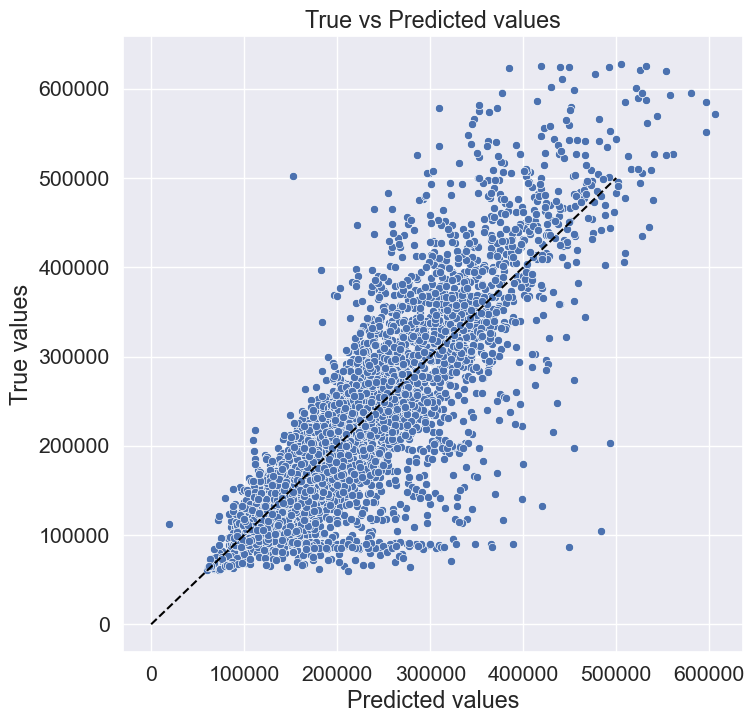

In [682]:
# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)

# y_train_preds = lr_model.predict(X_train)

# evaluate_preds(y_train, y_train_preds)

R2:	0.686
RMSE:	51954.984
MSE:	2699320394.945


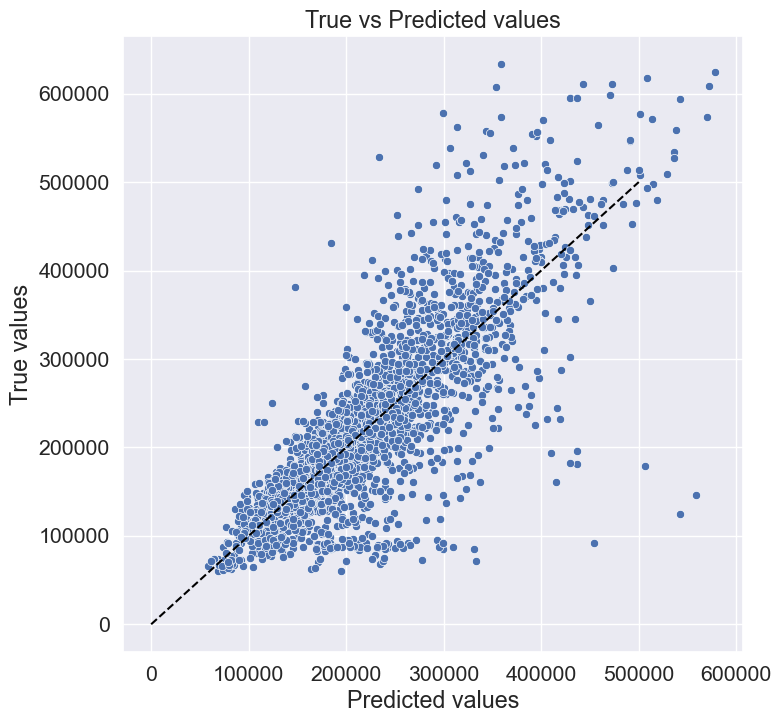

In [683]:
# y_valid_preds = lr_model.predict(X_valid)
# evaluate_preds(y_valid, y_valid_preds)

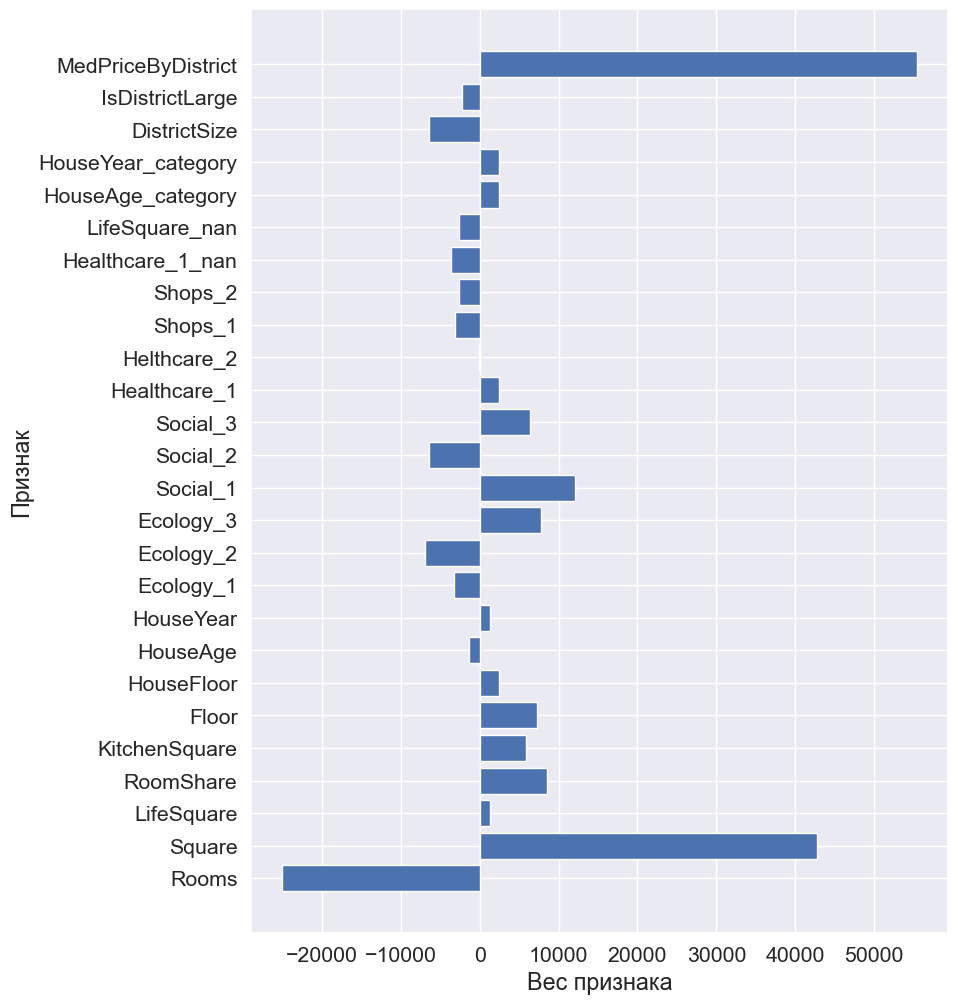

In [687]:
# # Построим веса признаков

# feature_names = X.columns.to_list()
# from pylab import rcParams

# rcParams["figure.figsize"] = 9, 12

# lr_model.fit(X_train, y_train)

# plt.barh(feature_names, lr_model.coef_.flatten())

# plt.xlabel("Вес признака")
# plt.ylabel("Признак")

# plt.show()

**2. DecisionTreeRegressor**
* R2:	0.658
* RMSE:	54225.333
* MSE:	2940386747.119


In [694]:
# # Подбираем гиперпараметры
# max_depth_values = np.arange(2, 20)

# r2_on_valid = []
# r2_on_train = []

# for i, value in enumerate(max_depth_values):
#     tree_model = DecisionTreeRegressor(max_depth=value, random_state=21)
    
#     tree_model.fit(X_train, y_train)
    
#     y_pred = tree_model.predict(X_valid)
#     y_pred_train = tree_model.predict(X_train)
      
#     r2_train = r2(y_train, y_pred_train)
#     r2_valid = r2(y_valid, y_pred)
    
#     if i % 4 == 2:
#         print('K = {}'.format(value))
#         print('\tr2_train = {}\n'.format(r2_train))
#         print('\tr2_valid = {}'.format(r2_valid))
       
    
#     r2_on_train.append(r2_train)
#     r2_on_valid.append(r2_valid)

K = 4
	r2_train = 0.6819372292211756

	r2_valid = 0.642472887489028
K = 8
	r2_train = 0.8173699843980283

	r2_valid = 0.6190666734542692
K = 12
	r2_train = 0.919184871838084

	r2_valid = 0.5490298227838905
K = 16
	r2_train = 0.9721338796962891

	r2_valid = 0.4982301628058543


In [697]:
# # На графике видим, что показатель max_depth = 6.5 является оптимальным, дальше модель уже переобучается.
# plt.rcParams['figure.figsize'] = 6, 4

# plt.plot(max_depth_values, r2_on_train, label="train")
# plt.plot(max_depth_values, r2_on_valid, label="valid")

# plt.xlabel('Значение параметра max_depth')
# plt.ylabel('r2')

# plt.legend()
# plt.grid()

# plt.show()

In [698]:
# tree_model = DecisionTreeRegressor(max_depth=6.5)

# tree_model.fit(X_train, y_train)

# y_valid_preds = tree_model.predict(X_valid)

# evaluate_preds(y_valid, y_valid_preds)

In [700]:
# # Видим признаки с набольшим весом
# plt.figure(figsize=(20,10))
# plot_tree(tree_model, feature_names=X_train.columns, filled = True, max_depth=2);

**3. RandomForestRegressor**
* R2:	0.739
* RMSE:	47382.434
* MSE:	2245095096.815

Превосходит результаты предыдущих моделей.
В требованиях к проекту указано использовать модели не сложнее RandomForest, значит, выбираем ее для работы с тестовой выборкой.

In [702]:
# Подбираем параметры с помощью GridSearchCV

parameters = {
    'n_estimators': [100, 150, 200],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}

gs = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [703]:
## Понадобилось 3min 3s для обучения
# %%time

# gs.fit(X_train, y_train)

CPU times: user 3min 2s, sys: 968 ms, total: 3min 3s
Wall time: 3min 3s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                         'max_features': array([5, 6, 7, 8]),
                         'n_estimators': [100, 150, 200]},
             scoring='r2')

In [704]:
# # Получаем наилучше параметры для модели
# gs.best_params_

{'max_depth': 9, 'max_features': 8, 'n_estimators': 100}

R2:	0.739
RMSE:	47382.434
MSE:	2245095096.815


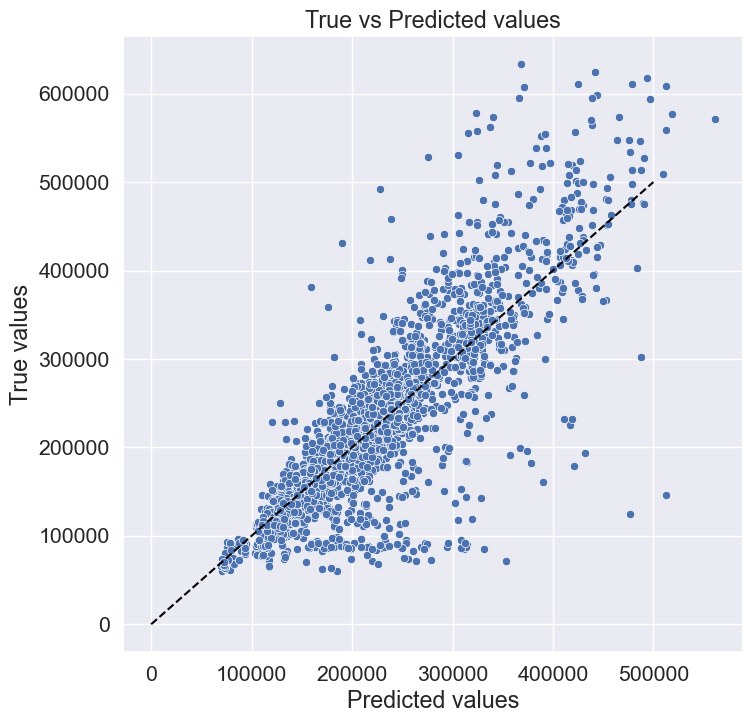

In [709]:
rf_model = RandomForestRegressor(max_depth=9, max_features=8, n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_valid_preds = rf_model.predict(X_valid)

evaluate_preds(y_valid, y_valid_preds)

In [708]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)[:10]

,feature_name,importance
25,MedPriceByDistrict,0.346935
1,Square,0.194872
23,DistrictSize,0.076613
0,Rooms,0.072451
2,LifeSquare,0.066455
3,RoomShare,0.037394
13,Social_2,0.034107
12,Social_1,0.029351
14,Social_3,0.024166
4,KitchenSquare,0.021563


**4. GradientBoostingRegressor** - применялся для отработки навыков, т.к. в требованиях к курсовой указано - его не брать в качестве финальной модели.

* R2:	0.746
* RMSE:	46719.868
* MSE:	2182746024.181

In [713]:
# gb_model = GradientBoostingRegressor(criterion='squared_error',
#                           min_samples_leaf=10,
#                           random_state=42
#                          )

In [714]:
# params = {'n_estimators':[50, 100, 200, 400], 
#           'max_depth':[3, 5, 7, 10]}

# gs = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )


In [723]:
# # Обучился за 36.9 s
# %%time
# gs.fit(X_train, y_train)

In [719]:
# gs.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [720]:
# gs.best_score_

0.7586474254705312

In [721]:
# gb_model = GradientBoostingRegressor(criterion='squared_error',
#                                         max_depth=5,
#                                         min_samples_leaf=10,
#                                         random_state=42,
#                                         n_estimators=100)

# gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', max_depth=5,
                          min_samples_leaf=10, random_state=42)

R2:	0.746
RMSE:	46719.868
MSE:	2182746024.181


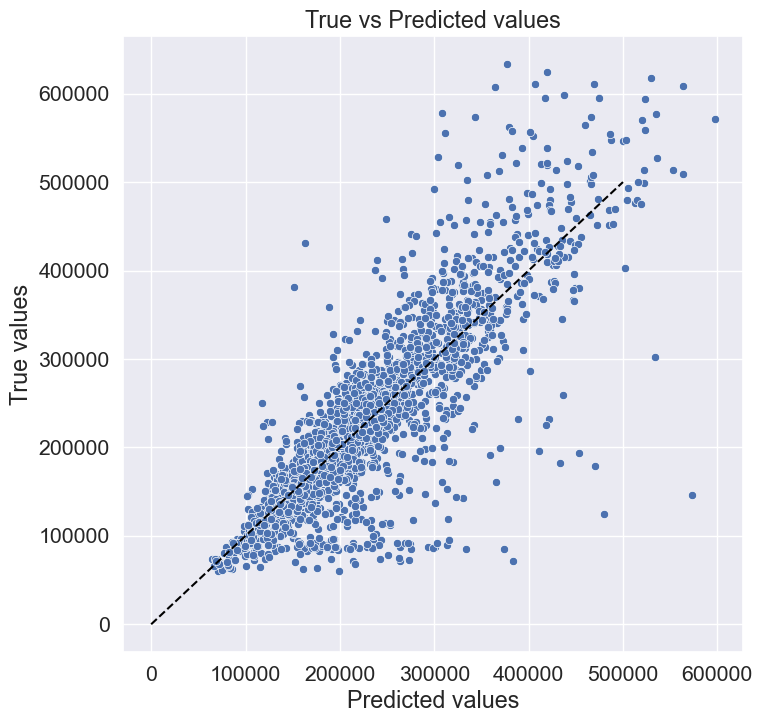

In [722]:
# y_valid_preds = gb_model.predict(X_valid)

# evaluate_preds(y_valid, y_valid_preds)

In [725]:
# Сохраняем финальную модель - RandomForestRegressor
with open('Final_model', 'wb') as f:
    pickle.dump(rf_model, f)

In [726]:
# with open('Final_model', 'rb') as file:
#     my_model = pickle.load(file)
    
# my_model

RandomForestRegressor(max_depth=9, max_features=8, random_state=42)

In [1357]:
y_test_preds = rf_model.predict(X_test.drop(columns='Id'))

In [1358]:
pd.DataFrame({ 'Id': test_df['Id'], 'Price': y_test_preds }).to_csv(TEST_DATASET_PRED_PATH, index=False)